In [76]:
import os
import pickle
from collections import Counter
from typing import List, Literal, Callable, Dict

import torch
import spacy
import numpy as np
import matplotlib.pyplot as plt

In [77]:
# !pip install -U spacy && \
# python -m spacy download en_core_web_sm && \
# python -m spacy download es_core_news_sm

Based on the paper "Sequence to Sequence Learning with Neural Networks" by the google brain team.
 https://proceedings.neurips.cc/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf

# 1. Preparación del Conjunto de Datos

## 1.1 Lectura del Conjunto de Datos

In [78]:
english_language = spacy.load("en_core_web_sm")
spanish_language = spacy.load("es_core_news_sm")

In [79]:
def read_file(file_path: str) -> List[str]:
    # Regresa todas las líneas en una lista
    with open(file_path, "rt") as f:
        file_text = f.read()
    return [line.strip().lower() for line in file_text.split("\n")]

In [80]:
english_lines = read_file("open_subtitles_english.txt")
spanish_lines = read_file("open_subtitles_spanish.txt")
print(f"len(english_lines): {len(english_lines):,}")
print(f"len(spanish_lines): {len(spanish_lines):,}")

len(english_lines): 999,848
len(spanish_lines): 999,848


## 1.2 Tokenización

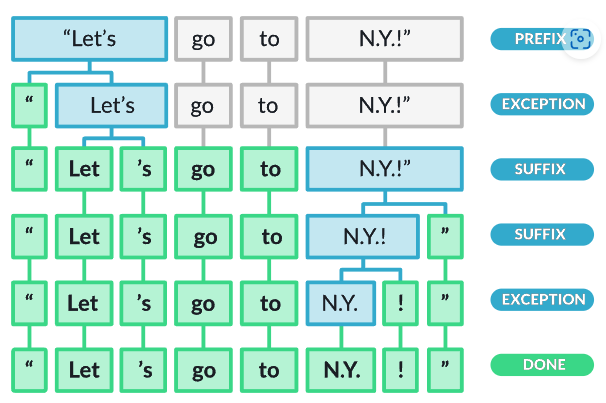

In [81]:
def tokenize_lines(
    lines: List[str],
    language: spacy.Language
) -> List[List[str]]:
    tokenized_lines = []
    for i, document in enumerate(language.pipe(lines, disable=['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner'])):
        tokenized_lines.append([token.text for token in document])
    return tokenized_lines


# Calcular los token para todas las oraciones del conjunto de datos.
english_lines_tokenized = tokenize_lines(english_lines, english_language)
spanish_lines_tokenized = tokenize_lines(spanish_lines, spanish_language)

print(f"len(english_lines_tokenized): {len(english_lines_tokenized):,}")
print(f"english_lines_tokenized[1]: {english_lines_tokenized[1]}", end="\n\n")

print(f"len(spanish_lines_tokenized): {len(spanish_lines_tokenized):,}")
print(f"spanish_lines_tokenized[1]: {spanish_lines_tokenized[1]}")

len(english_lines_tokenized): 999,848
english_lines_tokenized[1]: ['you', 'love', 'curry', ',', 'right', '?']

len(spanish_lines_tokenized): 999,848
spanish_lines_tokenized[1]: ['te', 'encanta', 'el', 'curry', ',', '¿', 'no', '?']


## 1.3 Distribución de Palabras

In [85]:
# El objeto Counter es una subclase de dict diseñada para contar objetos.
# Simplifica el proceso de contar y sumar las ocurrencias de cada objeto
# en un iterable, devolviendo un diccionario donde las llaves son los elementos
# contados y los valores son las veces que cada elemento aparece. EJemplo:
#     >>> Counter('panama')
#     Counter({'a': 3, 'p': 1, 'n': 1, 'm': 1})

# Obtenemos todos los tokens (todas las palabras) en inglés
all_tokens = []
for tokenized_line in english_lines_tokenized:
    for token in tokenized_line:
        all_tokens.append(token)

english_token_counts = Counter(all_tokens)
values = list(english_token_counts.values())

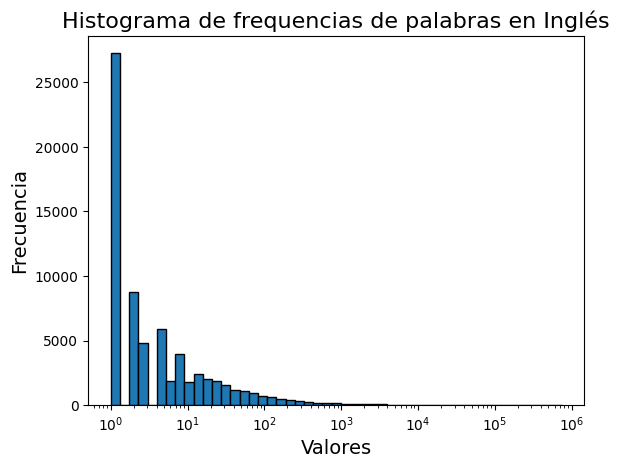

In [86]:
min_data, max_data = min(values), max(values)
log_bins = np.logspace(np.log10(min_data), np.log10(max_data), 50)
plt.gca().set_xscale('log')
plt.xlabel("Valores", fontsize=14)
plt.ylabel("Frecuencia", fontsize=14)
plt.title("Histograma de frequencias de palabras en Inglés", fontsize=16)
plt.hist(values, bins=log_bins, edgecolor="black")
plt.show()

In [87]:
# Obtenemos todos los tokens (todas las palabras)
all_tokens = []
for tokenized_line in spanish_lines_tokenized:
    for token in tokenized_line:
        all_tokens.append(token)

spanish_token_counts = Counter(all_tokens)
values = list(spanish_token_counts.values())

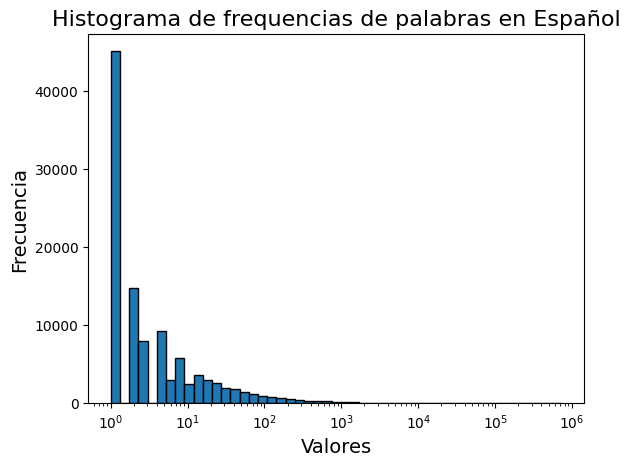

In [88]:
min_data, max_data = min(values), max(values)
log_bins = np.logspace(np.log10(min_data), np.log10(max_data), 50)
plt.gca().set_xscale('log')
plt.xlabel("Valores", fontsize=14)
plt.ylabel("Frecuencia", fontsize=14)
plt.title("Histograma de frequencias de palabras en Español", fontsize=16)
plt.hist(values, bins=log_bins, edgecolor="black")
plt.show()

In [89]:
def coverage(num_top_words: int, word_counts: Dict[str, int]) -> float:
    """Calcula el porcentaje de ocurrencias totales que representan las N
    palabras más frecuentes.

    :param num_top_words: Número de palabras más frecuentes a considerar.
    :param word_counts: Un diccionario que mapea palabras a su frecuencia de
        ocurrencia.
    :return: El porcentaje de ocurrencias totales que las N palabras más
        frecuentes representan.
    """
    ordered_word_counts = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True))
    top_words = list(ordered_word_counts.keys())[:num_top_words]
    covered = sum(v for k, v in ordered_word_counts.items() if v >= ordered_word_counts[top_words[-1]])
    return covered / sum(word_counts.values())

In [90]:
# Las primeras 10,000 palabras representan el 97% del texto
coverage(10_000, english_token_counts)

0.973882614344251

In [91]:
# Las primeras 10,000 palabras representan el 94% del texto
coverage(10_000, spanish_token_counts)

0.9442273395410251

## 1.4 Construcción de Vocabulario

In [92]:
class Vocabulary:
    def __init__(self, words: list[str], max_words: int) -> None:
        word_counts = Counter(words)
        self._words = [w for w, _ in word_counts.most_common(max_words)]
        self._word_to_index = {w: i for i, w in enumerate(self._words)}

    def __contains__(self, word: str) -> bool:
        return word in self._word_to_index

    def get_word_index(self, word: str) -> int:
        return self._word_to_index[word]

    def get_word_from_index(self, index: int) -> str:
        return self._words[index]

    def append_token(self, word: str) -> None:
        if word in self._word_to_index:
            raise ValueError(f"Word '{word}' already exists.")
        self._word_to_index[word] = len(self._words)
        self._words.append(word)


In [93]:
# Obtener la lista de tokens en inglés
english_words = []
for sentence in english_lines_tokenized:
    for word in sentence:
        english_words.append(word)

english_vocabulary = Vocabulary(english_words, max_words=10_000)
english_vocabulary.append_token("<unk>")  # Para los tokens no conocidos
english_vocabulary.append_token("<sos>")  # start of sentence
english_vocabulary.append_token("<eos>")  # end of sentence
english_vocabulary.append_token("<pad>")  # padding token

In [94]:
# Obtener la lista de tokens en español
spanish_words = []
for sentence in spanish_lines_tokenized:
    for word in sentence:
        spanish_words.append(word)

spanish_vocabulary = Vocabulary(spanish_words, max_words=10_000)
spanish_vocabulary.append_token("<unk>")  # Para los tokens no conocidos
spanish_vocabulary.append_token("<sos>")  # start of sentence
spanish_vocabulary.append_token("<eos>")  # end of sentence
spanish_vocabulary.append_token("<pad>")  # padding token

In [95]:
print(f"len(english_vocabulary._words): {len(english_vocabulary._words):,}")
print(f"len(spanish_vocabulary._words): {len(spanish_vocabulary._words):,}")

len(english_vocabulary._words): 10,004
len(spanish_vocabulary._words): 10,004


## 1.5 Construcción del Conjunto de Datos

In [96]:
class SubtitlesDataset(torch.utils.data.Dataset):
    def __init__(self, english_path: str, spanish_path: str) -> None:
        with open(english_path, "rt") as f:
            self._english_lines: list[str] = [line.rstrip("\n") for line in f]
        with open(spanish_path, "rt") as f:
            self._spanish_lines: list[str] = [line.rstrip("\n") for line in f]

    def __len__(self) -> int:
        return len(self._english_lines)

    def __getitem__(self, index: int) -> tuple:
        return self._english_lines[index], self._spanish_lines[index]

In [68]:
class LowercaseTransform:
    def __call__(self, text: str) -> str:
        return text.lower()


class TokenizeTransform:
    def __init__(self, language: spacy.Language) -> None:
        self._tokenizer = language.tokenizer

    def __call__(self, sentence: str) -> List[str]:
        return [token.text for token in self._tokenizer(sentence)]


class InsertSpecialTokensTransform:
    def __init__(self, vocabulary: Vocabulary) -> None:
        self._vocabulary = vocabulary

    def __call__(self, tokens: List[str]) -> List[str]:
        tokens = [token if token in self._vocabulary else "<unk>" for token in tokens]
        tokens = ["<sos>"] + tokens + ["<eos>"]
        return tokens


class PaddingTransform:
    def __call__(self, tokens: List[str], target_length: int) -> List[str]:
        return ["<pad>"] * (target_length - len(tokens)) + tokens


class TokenToIndexTransform:
    def __init__(self, vocabulary: Vocabulary) -> None:
        self._vocabulary = vocabulary

    def __call__(self, tokens: List[str]) -> List[int]:
        return [self._vocabulary.get_word_index(token) for token in tokens]


class ComposeTransform:
    def __init__(self, transforms: List[Callable]):
        self._transforms = transforms

    def __call__(self, batch: List[str]) -> torch.tensor:
        for t in self._transforms:
            output_batch = []
            for element in batch:
                if isinstance(t, PaddingTransform):
                    target_length = max([len(x) for x in batch])
                    element = t(element, target_length)
                else:
                    element = t(element)
                output_batch.append(element)
            batch = output_batch
        return torch.tensor(output_batch)

# 2. Model Definition

In [73]:
class Encoder(torch.nn.Module):
    def __init__(
        self,
        input_size: int,
        embedding_size: int,
        hidden_size: int,
        num_layers: int,
        padding_idx: int
    ) -> None:
        super().__init__()
        self.embedding = torch.nn.Embedding(
            num_embeddings=input_size,
            embedding_dim=embedding_size,
            padding_idx=padding_idx
        )
        self.rnn = torch.nn.LSTM(
            embedding_size,
            hidden_size,
            num_layers,
            batch_first=True
        )

    def forward(self, x):
        embedding = self.embedding(x)
        output, (hidden, cell) = self.rnn(embedding)
        return hidden, cell


class Decoder(torch.nn.Module):
    def __init__(
        self,
        input_size,
        embedding_size,
        hidden_size,
        output_size,
        num_layers,
        padding_idx: int
    ) -> None:
        super().__init__()
        self.embedding = torch.nn.Embedding(
            num_embeddings=input_size,
            embedding_dim=embedding_size,
            padding_idx=padding_idx
        )
        self.rnn = torch.nn.LSTM(
            embedding_size,
            hidden_size,
            num_layers,
            batch_first=True
        )
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        assert x.dtype == torch.long
        # x: secuencia objetivo usada como entrada del decodificador.
        #   target (verdadero)        = [<sos>, "Yo", "estoy", "hambriento", <eos>]
        #   x (entrada decodificador) = [<sos>, "Yo", "estoy", "hambriento"]   # sin el último elemento
        # Dimensiones: [batch_size, target_seq_len - 1]
        embedding = self.embedding(x)
        # embedding: [batch_size, target_seq_len - 1, embedding_size]
        output, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # output: [batch_size, target_seq_len - 1, hidden_size]
        logits = self.fc(output)
        # logits: [batch_size, target_seq_len -1, output_size]
        return logits, hidden, cell


class SequenceToSequence(torch.nn.Module):
    def __init__(self, encoder: torch.nn.Module, decoder: torch.nn.Module) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target):
        # source: [batch_size, source_seq_len]
        # target: [batch_size, target_seq_len]
        hidden, cell = self.encoder(source)  # [num_layers, N, H], [num_layers, N, H]
        # target[:, :-1]: No necesitamos hacer predicción con el último token ["<sos>", "Hola", "mundo", "<eos>]
        logits, hidden, cell = self.decoder(target[:, :-1], hidden, cell)  # Ejecuta todas las capas
        return logits  # [batch_size, target_seq_len - 1, output_size]

    def predict(
        self,
        source,
        sos_index: int,
        eos_index: int,
        device: torch.device,
        max_prediction_len: int = 20
    ) -> List[int]:
        # source.shape: [source_seq_len,]
        # source shape becomes [1, source_seq_len] after unsqueeze
        hidden, cell = self.encoder(source.unsqueeze(0))
        # hidden.shape: [num_layers, 1, hidden_size], cell.shape: [num_layers, 1, hidden_size]

        predictions_indices = []
        # Initialize the input token as <SOS> token
        input_token = torch.tensor([[sos_index]], dtype=torch.long).to(device)  # torch.Size([1, 1])
        while len(predictions_indices) < max_prediction_len:
            # Embed the input token
            input_embedding = self.decoder.embedding(input_token)  # torch.Size([1, 1, 300]) [batch_size, seq_len, emb_dim]

            # Get the output, hidden, and cell states from the decoder
            output, (hidden, cell) = self.decoder.rnn(input_embedding, (hidden, cell))

            # Get the logits and find the token with the maximum score
            logits = self.decoder.fc(output)
            prediction_index = torch.argmax(logits, dim=-1)

            # Append the predicted token index
            predictions_indices.append(prediction_index.item())

            # Check for <EOS> token
            if prediction_index.item() == eos_index:
                break

            # Update the input token for the next iteration with the predicted token
            input_token = prediction_index  # torch.Size([1, 1])

        return predictions_indices


def translate_sentence(
    sentence: List[str],
    model: torch.nn.Module,
    device=torch.device
) -> str:
    # Remember english_transform returns a tensor of indices
    sentence = english_transform([sentence]).squeeze(0).to(device)
    model.eval()
    with torch.no_grad():
        predictions_indices = model.predict(
            source=sentence,
            sos_index=english_vocabulary.get_word_index("<sos>"),
            eos_index=english_vocabulary.get_word_index("<eos>"),
            device=device
        )
    model.train()
    sentence.cpu()
    return " ".join([spanish_vocabulary.get_word_from_index(o) for o in predictions_indices])

# 3. Training Loop

In [74]:
# Hiperparámetros
num_epochs = 5
learning_rate = 0.001
batch_size = 2
true_batch_size = 100
assert true_batch_size % batch_size == 0
accumulation_steps = true_batch_size // batch_size

# Create Dataset and Dataloader
english_transform = ComposeTransform([
    LowercaseTransform(),
    TokenizeTransform(english_language),
    InsertSpecialTokensTransform(english_vocabulary),
    PaddingTransform(),
    TokenToIndexTransform(english_vocabulary),
])
spanish_transform = ComposeTransform([
    LowercaseTransform(),
    TokenizeTransform(spanish_language),
    InsertSpecialTokensTransform(spanish_vocabulary),
    PaddingTransform(),
    TokenToIndexTransform(spanish_vocabulary),
])

dataset = SubtitlesDataset(
    english_path="open_subtitles_english.txt",
    spanish_path="open_subtitles_spanish.txt"
)

# Collate function to apply transforms per batch
def collate_fn(batch):
    english_batch = [en for en, _ in batch]
    spanish_batch = [es for _, es in batch]
    return {
        "input": english_transform(english_batch),
        "target": spanish_transform(spanish_batch)
    }

# DataLoader
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

# Model parameters
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")
hidden_size = 1_024
num_layers = 2

# Model Declaration
encoder_net = Encoder(
    input_size=10_004,
    embedding_size=300,
    hidden_size=hidden_size,
    num_layers=num_layers,
    padding_idx=english_vocabulary.get_word_index("<pad>")
).to(device)
decoder_net = Decoder(
    input_size=10_004,
    embedding_size=300,
    hidden_size=hidden_size,
    output_size=10_004,
    num_layers=num_layers,
    padding_idx=spanish_vocabulary.get_word_index("<pad>")
).to(device)
model = SequenceToSequence(encoder_net, decoder_net).to(device)

# Training loop
criterion = torch.nn.CrossEntropyLoss(ignore_index=spanish_vocabulary.get_word_index("<pad>"))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
test_sentence = "Why do you let those losers bully you like that?"
for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}/{num_epochs}")
    batch_loss = 0
    for batch_idx, batch in enumerate(data_loader):
        if (batch_idx + 1) % (batch_stats := 900) == 0:
            print(f"batch_idx: {batch_idx + 1}, avg_loss: {batch_loss / batch_stats}")
            batch_loss = 0
            translated_test_sentence = translate_sentence(test_sentence, model, device)
            print(f"translated_test_sentence: {translated_test_sentence}")

        input = batch["input"].to(device)
        target = batch["target"].to(device)
        output = model(input, target)  # [batch_size, target_seq_len - 1, output_size]
        output = output.reshape(-1, output.shape[2])

        target = target[:, 1:]
        target = target.reshape(-1)  # Flattens to one dimensional vector

        # CrossEntropyLoss espera [num_samples, num_classes] para las predicciones y [num_samples] para los objetivos
        loss = criterion(output, target)
        batch_loss += loss
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            optimizer.zero_grad()

Epoch: 1/5
batch_idx: 900, avg_loss: 5.995360851287842
translated_test_sentence: - ¿ . <eos>
batch_idx: 1800, avg_loss: 4.8015055656433105
translated_test_sentence: - ¿ , , , , , . <eos>
batch_idx: 2700, avg_loss: 4.576344013214111
translated_test_sentence: ¿ , ¿ , <unk> , <unk> . <eos>
batch_idx: 3600, avg_loss: 4.377992630004883
translated_test_sentence: ¿ qué <unk> , ¿ qué <unk> ? <eos>
batch_idx: 4500, avg_loss: 4.3239264488220215
translated_test_sentence: ¿ qué qué <unk> ? <eos>
batch_idx: 5400, avg_loss: 4.183664321899414
translated_test_sentence: ¿ qué qué <unk> ? <eos>
batch_idx: 6300, avg_loss: 4.092257022857666
translated_test_sentence: ¿ qué qué te <unk> ? <eos>
batch_idx: 7200, avg_loss: 4.038824558258057
translated_test_sentence: ¿ qué qué que no me <unk> ? <eos>
batch_idx: 8100, avg_loss: 4.005438327789307
translated_test_sentence: ¿ qué es que no te <unk> ? <eos>
batch_idx: 9000, avg_loss: 3.908167839050293
translated_test_sentence: ¿ qué qué <unk> ? <eos>
batch_idx: 990